In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from src import mef_test
import sklearn
from src import functions

/home/max/anaconda3/envs/tanzania/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
X_train = pd.read_csv('../data/train_data.csv')

X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
X_train.construction_year.describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [254]:
def combiner(row, col_1, col_2):
    if row[col_1]!=row[col_2]:
        return f'{row[col_1]}/{row[col_2]}'
    else:
        return row[col_1]
    
def fill_unknown(row, col_1, col_2, unknown):
    if (row[col_1] in unknown) &\
       (row[col_2] in unknown):
        row[col_1] = 'unknown'
        row[col_2] = 'unknown'
        return row
    elif row[col_1] in unknown:
        row[col_1] = row[col_2]
    elif row[col_2] in unknown:
        row[col_2] = row[col_1]
    return row

In [255]:
X_train['waterpoint_type/group'] = X_train.apply(lambda row: combiner(row, 'waterpoint_type', 'waterpoint_type_group'), axis=1)

In [256]:
X_train['waterpoint_type/group'].value_counts()

communal standpipe                                28522
hand pump                                         17488
other                                              6380
communal standpipe multiple/communal standpipe     6103
improved spring                                     784
cattle trough                                       116
dam                                                   7
Name: waterpoint_type/group, dtype: int64

# Management

In [257]:
col_1 = 'scheme_management'
col_2 = 'management'

X_train[col_1] = X_train[col_1].fillna('na')
X_train[col_2] = X_train[col_2].fillna('na')

X_train[col_2] = X_train[col_2].map(lambda x: x.lower())
X_train[col_1] = X_train[col_1].map(lambda x: x.lower())

X_train[col_1].value_counts()

vwc                 36793
wug                  5206
na                   3877
water authority      3153
wua                  2883
water board          2748
parastatal           1680
private operator     1063
company              1061
other                 766
swc                    97
trust                  72
none                    1
Name: scheme_management, dtype: int64

In [258]:
X_train[col_2].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [259]:
X_train = X_train.apply(lambda row: fill_unknown(row, col_1, col_2, ['na', 'other', 'none', 'unknown']), axis=1)
X_train[col_2].value_counts()

vwc                 40632
wug                  6534
water board          2955
wua                  2538
private operator     1975
parastatal           1772
unknown              1181
water authority       949
company               687
other - school         99
trust                  78
Name: management, dtype: int64

In [260]:
X_train[col_1].value_counts()

vwc                 39285
wug                  5952
water authority      3174
wua                  2889
water board          2748
parastatal           1692
private operator     1246
unknown              1181
company              1062
swc                    97
trust                  74
Name: scheme_management, dtype: int64

In [261]:
X_train['scheme_management/management'] = X_train.apply(lambda row: combiner(row, col_1, col_2), axis=1)
X_train['scheme_management/management'].value_counts()

vwc                       38005
wug                        5533
wua                        2378
water board                2181
parastatal                 1584
                          ...  
trust/company                 1
private operator/trust        1
company/wug                   1
trust/parastatal              1
trust/water authority         1
Name: scheme_management/management, Length: 66, dtype: int64

In [262]:
top = X_train['scheme_management/management'].value_counts()[X_train['scheme_management/management'].value_counts()>100]
top

vwc                                 38005
wug                                  5533
wua                                  2378
water board                          2181
parastatal                           1584
water authority/vwc                  1297
unknown                              1181
private operator                     1150
water authority                       933
vwc/wug                               823
water authority/water board           730
company                               677
water board/vwc                       411
wug/vwc                               401
wua/vwc                               238
company/private operator              224
wua/private operator                  195
water authority/private operator      176
vwc/private operator                  160
company/vwc                           135
vwc/parastatal                        123
water board/wug                       111
vwc/wua                               109
Name: scheme_management/management

In [263]:
X_train['scheme_management/management'] = X_train['scheme_management/management'].map(lambda x: x if x in top.index else 'binned')
X_train['scheme_management/management'].value_counts()

vwc                                 38005
wug                                  5533
wua                                  2378
water board                          2181
parastatal                           1584
water authority/vwc                  1297
unknown                              1181
private operator                     1150
water authority                       933
vwc/wug                               823
water authority/water board           730
company                               677
binned                                645
water board/vwc                       411
wug/vwc                               401
wua/vwc                               238
company/private operator              224
wua/private operator                  195
water authority/private operator      176
vwc/private operator                  160
company/vwc                           135
vwc/parastatal                        123
water board/wug                       111
vwc/wua                           

# Funder

In [264]:
misspellings = {'dwe&': 'dwe',
 'dwe': 'dwe',
 'dwe/': 'dwe',
 'dwe}': 'dwe',
 'dw#': 'dwe',
 'dw$': 'dwe',
 'dw': 'dwe',
 'dw e': 'dwe',
 'dawe': 'dwe',
 'dweb': 'dwe',
 'government': 'central government',
 'government of tanzania': 'central government',
 'gove': 'central government',
 'tanzanian government': 'central government',
 'governme': 'central government',
 'goverm': 'central government',
 'tanzania government': 'central government',
 'cental government': 'central government',
 'gover': 'central government',
 'centra government': 'central government',
 'go': 'central government',
 'centr': 'central government',
 'central govt': 'central government',
 'cebtral government': 'central government',
 'governmen': 'central government',
 'govern': 'central government',
 'central government': 'central government',
 'olgilai village community': 'community',
 'maseka community': 'community',
 'kitiangare village community': 'community',
 'sekei village community': 'community',
 'igolola community': 'community',
 'comunity': 'community',
 'mtuwasa and community': 'community',
 'village community members': 'community',
 'district community j': 'community',
 'marumbo community': 'community',
 'ngiresi village community': 'community',
 'community': 'community',
 'village community': 'community',
 'commu': 'community',
 'ilwilo community': 'community',
 'communit': 'community',
 'taboma/community': 'community',
 'oldadai village community': 'community',
 'villagers': 'community',
 'kkkt': 'kkkt',
 'kkkt dme': 'kkkt',
 'kkkt-dioces ya pare': 'kkkt',
 'kkkt katiti juu': 'kkkt',
 'kkkt leguruki': 'kkkt',
 'kkkt mareu': 'kkkt',
 'kkkt ndrumangeni': 'kkkt',
 'kk': 'kkkt',
 'kkkt church': 'kkkt',
 'kkkt kilinga': 'kkkt',
 'kkkt canal': 'kkkt',
 'kkt': 'kkkt',
 'lutheran church': 'kkkt',
 'luthe': 'kkkt',
 'haidomu lutheran church': 'kkkt',
 'world vision': 'world vision',
 'world vission': 'world vision',
 'world visiin': 'world vision',
 'world division': 'world vision',
 'world': 'world vision',
 'world nk': 'world vision',
 'district council': 'district council',
 'district counci': 'district council',
 'district  council': 'district council',
 'mbozi district council': 'district council',
 'wb / district council': 'district council',
 'mbulu district council': 'district council',
 'serengeti district concil': 'district council',
 'district water department': 'district council',
 'tabora municipal council': 'district council',
 'hesawa': 'hesawa',
 'esawa': 'hesawa',
 'hesaw': 'hesawa',
 'unknown installer': 'unknown'}

def bin_installer(df):
    """
    input: dataframe
    output: returns a new dataframe with a new column, installer_binned, that has a cleaned installer row
    """
    new_df = df.copy()
    new_df['installer_binned'] = new_df['installer']
    new_df['installer_binned'] = new_df['installer_binned'].fillna('unknown')
    new_df['installer_binned'] = new_df['installer_binned'].map(lambda x: x.lower())
    new_df['installer_binned'] = new_df['installer_binned'].replace(misspellings)
    
    return new_df

def bin_funder(df):
    """
    input: dataframe
    output: returns a new dataframe with a new column, installer_binned, that has a cleaned installer row
    """
    new_df = df.copy()
    new_df['funder_binned'] = new_df['funder']
    new_df['funder_binned'] = new_df['funder_binned'].fillna('unknown')
    new_df['funder_binned'] = new_df['funder_binned'].map(lambda x: x.lower())
    new_df['funder_binned'] = new_df['funder_binned'].replace(misspellings)

    return new_df

In [265]:
new_df = bin_installer(X_train)

In [266]:
new_df['installer'].value_counts()

DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
Jumanne                     1
George mtoto company        1
BALYEH                      1
Ambrose                     1
DBSP                        1
Name: installer, Length: 2145, dtype: int64

In [267]:
new_df['installer_binned'].value_counts()

dwe                   17678
central government     3871
unknown                3660
community              1976
hesawa                 1399
                      ...  
mbeje                     1
dfid                      1
steven nyangarika         1
adam kea                  1
shipo constructors        1
Name: installer_binned, Length: 1863, dtype: int64

In [268]:
new_df = bin_funder(new_df)

new_df['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Uniseg                       1
Esawa                        1
Stephano Paulo               1
Said Salum Ally              1
Muniko                       1
Name: funder, Length: 1897, dtype: int64

In [269]:
new_df['funder_binned'].value_counts()

central government    9267
unknown               3639
danida                3114
hesawa                2208
kkkt                  1408
                      ... 
nassan                   1
panone                   1
fabia                    1
iucn                     1
padri                    1
Name: funder_binned, Length: 1866, dtype: int64

In [270]:
col_1 = 'funder_binned'
col_2 = 'installer_binned'

new_df[col_1] = new_df[col_1].fillna('na')
new_df[col_2] = new_df[col_2].fillna('na')

new_df[col_2] = new_df[col_2].map(lambda x: x.lower())

new_df[col_1] = new_df[col_1].map(lambda x: x.lower())

new_df[new_df[col_2]==new_df[col_1]]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,waterpoint_type/group,scheme_management/management,installer_binned,funder_binned
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,roman,roman
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,wug,grumeti,grumeti
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,communal standpipe multiple/communal standpipe,vwc,unicef,unicef
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,enough,machine dbh,borehole,groundwater,hand pump,hand pump,hand pump,vwc,dwsp,dwsp
10,49056,0.0,2011-02-20,Private,62,Private,39.209518,-7.034139,Mzee Hokororo,0,...,enough,machine dbh,borehole,groundwater,other,other,other,private operator,private,private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59387,26640,100.0,2013-03-12,0,25,0,39.176480,-6.957098,Kwa Maliba,0,...,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,communal standpipe,wua,0,0
59391,44885,0.0,2013-08-03,Government Of Tanzania,540,Government,38.044070,-4.272218,Kwa,0,...,enough,river,river/lake,surface,communal standpipe,communal standpipe,communal standpipe,water authority/vwc,central government,central government
59392,40607,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Benard Charles,0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,central government,central government
59393,48348,0.0,2012-10-27,Private,0,Private,33.866852,-4.287410,Kwa Peter,0,...,insufficient,dam,dam,surface,other,other,other,water authority/private operator,private,private


In [271]:
new_df = new_df.apply(lambda row: fill_unknown(row, col_1, col_2, ['0', 'other', 'unknown']), axis=1)
new_df[col_2].value_counts()

dwe                   17679
unknown                4363
central government     3875
community              1979
hesawa                 1404
                      ...  
miab                      1
babu sajini               1
mamvua kakungu            1
cristan outrich           1
shipo constructors        1
Name: installer_binned, Length: 1879, dtype: int64

In [272]:
new_df['funder/installer'] = new_df.apply(lambda row: combiner(row, col_1, col_2), axis=1)
new_df['funder/installer'].value_counts()

unknown                      4363
central government/dwe       4357
central government           2802
hesawa/dwe                   1301
danida                       1046
                             ... 
danida/danda                    1
dawasco/dwe                     1
villa                           1
namungo miners/namungo          1
central government/vtecos       1
Name: funder/installer, Length: 3400, dtype: int64

In [273]:
top = new_df['funder/installer'].value_counts()[new_df['funder/installer'].value_counts() > 200]
top

unknown                                4363
central government/dwe                 4357
central government                     2802
hesawa/dwe                             1301
danida                                 1046
kkkt                                   1046
rwssp/dwe                               916
hesawa                                  862
world vision                            702
dhv/dwe                                 679
central government/rwe                  645
danida/dwe                              626
danida/danid                            623
dwsp/dwe                                617
germany republi/ces                     610
unicef/dwe                              562
tcrs                                    537
central government/district council     531
danida/central government               525
dwe                                     506
netherlands/dwe                         466
district council                        456
hifab/hesawa                    

In [274]:
new_df['funder/installer'] = new_df['funder/installer'].map(lambda x: x if x in top.index else 'binned')
new_df['funder/installer'].value_counts()

X_train = new_df

# Extraction

In [275]:
col_1 = 'extraction_type'
col_2 = 'extraction_type_group'

X_train[col_1] = X_train[col_1].fillna('na')
X_train[col_2] = X_train[col_2].fillna('na')

X_train[col_2] = X_train[col_2].map(lambda x: x.lower())

X_train[col_1] = X_train[col_1].map(lambda x: x.lower())

X_train[X_train[col_2]==X_train[col_1]]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,waterpoint_type/group,scheme_management/management,installer_binned,funder_binned,funder/installer
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,spring,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,roman,roman,binned
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,wug,grumeti,grumeti,binned
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,dam,dam,surface,communal standpipe multiple,communal standpipe,communal standpipe multiple/communal standpipe,vwc,world vision,lottery club,binned
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,communal standpipe multiple/communal standpipe,vwc,unicef,unicef,unicef
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,unknown,artisan,action in a,binned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,spring,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,water board,ces,germany republi,germany republi/ces
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,river,river/lake,surface,communal standpipe,communal standpipe,communal standpipe,vwc,cefa,cefa-njombe,binned
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,machine dbh,borehole,groundwater,hand pump,hand pump,hand pump,vwc,unknown,unknown,unknown
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,shallow well,shallow well,groundwater,hand pump,hand pump,hand pump,vwc,musa,malec,binned


In [276]:
X_train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [277]:
X_train['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [278]:
X_train['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [279]:
X_train['extraction_type/group'] = X_train.apply(lambda row: combiner(row, col_1, col_2), axis=1)
X_train['extraction_type/group'].value_counts()

gravity                                     26780
nira/tanira                                  8154
other                                        6430
submersible                                  4764
swn 80                                       3670
mono                                         2865
india mark ii                                2400
afridev                                      1770
ksb/submersible                              1415
other - rope pump/rope pump                   451
other - swn 81/other handpump                 229
windmill/wind-powered                         117
india mark iii                                 98
cemo/other motorpump                           90
other - play pump/other handpump               85
walimi/other handpump                          48
climax/other motorpump                         32
other - mkulima/shinyanga/other handpump        2
Name: extraction_type/group, dtype: int64

In [280]:
top = X_train['extraction_type/group'].value_counts()[:100]
top

gravity                                     26780
nira/tanira                                  8154
other                                        6430
submersible                                  4764
swn 80                                       3670
mono                                         2865
india mark ii                                2400
afridev                                      1770
ksb/submersible                              1415
other - rope pump/rope pump                   451
other - swn 81/other handpump                 229
windmill/wind-powered                         117
india mark iii                                 98
cemo/other motorpump                           90
other - play pump/other handpump               85
walimi/other handpump                          48
climax/other motorpump                         32
other - mkulima/shinyanga/other handpump        2
Name: extraction_type/group, dtype: int64

In [281]:
X_train['extraction_type/group'] = X_train['extraction_type/group'].map(lambda x: x if x in top.index else 'binned')
X_train['extraction_type/group'].value_counts()

gravity                                     26780
nira/tanira                                  8154
other                                        6430
submersible                                  4764
swn 80                                       3670
mono                                         2865
india mark ii                                2400
afridev                                      1770
ksb/submersible                              1415
other - rope pump/rope pump                   451
other - swn 81/other handpump                 229
windmill/wind-powered                         117
india mark iii                                 98
cemo/other motorpump                           90
other - play pump/other handpump               85
walimi/other handpump                          48
climax/other motorpump                         32
other - mkulima/shinyanga/other handpump        2
Name: extraction_type/group, dtype: int64

# Extraction iteration two

In [282]:
col_1 = 'extraction_type_class'
col_2 = 'extraction_type/group'

X_train[col_1] = X_train[col_1].fillna('na')
X_train[col_2] = X_train[col_2].fillna('na')

X_train[col_2] = X_train[col_2].map(lambda x: x.lower())

X_train[col_1] = X_train[col_1].map(lambda x: x.lower())

X_train[X_train[col_2]==X_train[col_1]]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source_type,source_class,waterpoint_type,waterpoint_type_group,waterpoint_type/group,scheme_management/management,installer_binned,funder_binned,funder/installer,extraction_type/group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,roman,roman,binned,gravity
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,wug,grumeti,grumeti,binned,gravity
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,dam,surface,communal standpipe multiple,communal standpipe,communal standpipe multiple/communal standpipe,vwc,world vision,lottery club,binned,gravity
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,borehole,groundwater,communal standpipe multiple,communal standpipe,communal standpipe multiple/communal standpipe,vwc,unicef,unicef,unicef,submersible
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,unknown,artisan,action in a,binned,gravity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,40607,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Benard Charles,0,...,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,central government,central government,central government,gravity
59393,48348,0.0,2012-10-27,Private,0,Private,33.866852,-4.287410,Kwa Peter,0,...,dam,surface,other,other,other,water authority/private operator,private,private,binned,gravity
59394,11164,500.0,2011-03-09,World Bank,351,ML appro,37.634053,-6.124830,Chimeredya,0,...,borehole,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,ml appro,world bank,binned,submersible
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,water board,ces,germany republi,germany republi/ces,gravity


In [283]:
X_train['extraction_type/group/class'] = X_train.apply(lambda row: combiner(row, col_1, col_2), axis=1)
X_train['extraction_type/group/class'].value_counts()

gravity                                              26780
handpump/nira/tanira                                  8154
other                                                 6430
submersible                                           4764
handpump/swn 80                                       3670
motorpump/mono                                        2865
handpump/india mark ii                                2400
handpump/afridev                                      1770
submersible/ksb/submersible                           1415
rope pump/other - rope pump/rope pump                  451
handpump/other - swn 81/other handpump                 229
wind-powered/windmill/wind-powered                     117
handpump/india mark iii                                 98
motorpump/cemo/other motorpump                          90
handpump/other - play pump/other handpump               85
handpump/walimi/other handpump                          48
motorpump/climax/other motorpump                        

In [284]:
X_train['permit'].fillna('na')
X_train['permit'] = X_train['permit'].map(str)

# Year

In [285]:
X_train[X_train['construction_year']>0].construction_year.describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

In [286]:
def bin_year(year):
    if year<1960:
        return 'unknown'
    elif year>=1960 and year<1970:
        return '1960-1970'
    elif year>=1970 and year<1980:
        return '1970-1980'
    elif year>=1980 and year<1990:
        return '1980-1990'
    elif year>=1990 and year<2000:
        return '1990-2000'
    elif year>=2000 and year<2010:
        return '2000-2010'
    elif year>=2010 and year<2020:
        return '2010-2020'
    else:
        return year

In [287]:
X_train['decade'] = X_train['construction_year'].map(bin_year)
X_train['decade']

0        1990-2000
1        2010-2020
2        2000-2010
3        1980-1990
4          unknown
           ...    
59395    1990-2000
59396    1990-2000
59397      unknown
59398      unknown
59399    2000-2010
Name: decade, Length: 59400, dtype: object

In [288]:
X_train.decade.value_counts()

unknown      20709
2000-2010    15330
1990-2000     7678
1980-1990     5578
2010-2020     5161
1970-1980     4406
1960-1970      538
Name: decade, dtype: int64

In [289]:
X_train = functions.combine_installer_funder(X_train)

# WARNING SHOULD BE SPLIT TO TWO NOTEBOOKS

## Class imbalance

In [290]:
non_zeros = X_train[X_train['construction_year']>0]
non_zeros.decade.value_counts()

2000-2010    15330
1990-2000     7678
1980-1990     5578
2010-2020     5161
1970-1980     4406
1960-1970      538
Name: decade, dtype: int64

In [291]:
def create_decade_columns(decade, target_decade):
    if decade == target_decade:
        return 1
    else:
        return 0
    


non_zeros['2000-2010'] = non_zeros['decade'].map(lambda val: create_decade_columns(val, '2000-2010'))


decades = ['2000-2010',
'1990-2000',
'1980-1990',
'2010-2020',
'1970-1980',
'1960-1970']

for decade in decades:
    non_zeros[decade] = non_zeros['decade'].map(lambda val: create_decade_columns(val, decade))

<ipython-input-291-ad47fe61b22c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zeros['2000-2010'] = non_zeros['decade'].map(lambda val: create_decade_columns(val, '2000-2010'))
<ipython-input-291-ad47fe61b22c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zeros[decade] = non_zeros['decade'].map(lambda val: create_decade_columns(val, decade))


In [292]:
non_zeros.loc[:,decades]

,2000-2010,1990-2000,1980-1990,2010-2020,1970-1980,1960-1970
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
5,1,0,0,0,0,0
...,...,...,...,...,...,...
59391,0,0,0,0,0,1
59394,1,0,0,0,0,0
59395,0,1,0,0,0,0
59396,0,1,0,0,0,0


In [309]:
zeros = X_train[X_train['construction_year']==0]


zeros = functions.combine_managements(zeros)
zeros = functions.combine_waterpoint(zeros)
zeros = functions.clean_permit(zeros)
zeros = functions.combine_installer_funder(zeros)
zeros = functions.combine_extraction(zeros)

zeros = zeros.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                   'management_group', 'permit', 'district_code']]

/home/max/flatiron/chi-ds/module_3/week_3/projects/tanzaniawellclassification/src/functions.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_1] = df[col_1].fillna('na')
/home/max/flatiron/chi-ds/module_3/week_3/projects/tanzaniawellclassification/src/functions.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_2] = df[col_2].fillna('na')
/home/max/flatiron/chi-ds/module_3/week_3/projects/tanzaniawellclassification/src/functions.py:250: SettingWithCopyWarning: 
A value is trying to be s

In [304]:
funder_installer_ohe = pickle.load(open('funder_installer_ohe.sav', 'rb'))
extraction_type_group_class_ohe = pickle.load(open('extraction_type_group_class_ohe.sav', 'rb'))
scheme_management_management_ohe = pickle.load(open('scheme_management_management_ohe.sav', 'rb'))
management_group_ohe = pickle.load(open('management_group_ohe.sav', 'rb'))
source_type_ohe = pickle.load(open('source_type_ohe.sav', 'rb'))
source_ohe = pickle.load(open('source_ohe.sav', 'rb'))
waterpoint_type_group_ohe = pickle.load(open('waterpoint_type_group_ohe.sav', 'rb'))
permit_ohe = pickle.load(open('permit_ohe.sav', 'rb'))
basin_ohe = pickle.load(open('basin_ohe.sav', 'rb'))
district_code_ohe = pickle.load(open('district_code_ohe.sav', 'rb'))
region_code_ohe = pickle.load(open('region_code_ohe.sav', 'rb'))



In [319]:
X_test_all_features = zeros.copy().reset_index().drop("index", axis=1)

X_test_all_features = encode_and_concat_feature(X_test_all_features, 'funder/installer', funder_installer_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "extraction_type/group/class", extraction_type_group_class_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "scheme_management/management", scheme_management_management_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "management_group", management_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source_type", source_type_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source", source_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "waterpoint_type/group", waterpoint_type_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "permit", permit_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "basin", basin_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "district_code", district_code_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "region_code", region_code_ohe)

In [311]:
X_test_all_features

,adb/dwe,amref,binned,central government,central government/community,central government/district council,central government/dwe,central government/rwe,ces(gmbh)/dwe,community,...,17,18,19,20,21,24,60,80,90,99
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20705,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20706,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [314]:
import pickle
model = pickle.load(open('year_predictor.sav', 'rb'))

predictions_ = model.predict_proba(X_test_all_features)

In [313]:
model.classes_

array(['1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010',
       '2010-2020'], dtype=object)

In [317]:
prediction_df = pd.DataFrame(predictions_, columns=model.classes_)

prediction_df

,1960-1970,1970-1980,1980-1990,1990-2000,2000-2010,2010-2020
0,0.000000,0.010000,0.010000,0.223262,0.330953,0.425784
1,0.005823,0.099187,0.061778,0.656288,0.160026,0.016899
2,0.002981,0.050417,0.045974,0.269786,0.431863,0.198980
3,0.000000,0.022896,0.102216,0.112690,0.307593,0.454604
4,0.000000,0.016045,0.066381,0.140411,0.276963,0.500200
...,...,...,...,...,...,...
20704,0.000000,0.034356,0.065922,0.333805,0.302150,0.263768
20705,0.176136,0.399125,0.083366,0.087561,0.145376,0.108436
20706,0.040000,0.075962,0.178182,0.100217,0.300241,0.305398
20707,0.200000,0.022571,0.157794,0.089396,0.411256,0.118982


In [224]:
df = X_train[X_train['construction_year']!=0]

In [225]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=1)

In [226]:
b = train[train['decade'] == '2000-2010']
c = train[train['decade'] == '1990-2000']
d = train[train['decade'] == '1980-1990']
e = train[train['decade'] == '2010-2020']
f = train[train['decade'] == '1970-1980']
g = train[train['decade'] == '1960-1970']


In [227]:
b_bal = b.loc[np.random.choice(b.index, size=10000, replace=True)]
c_bal = c.loc[np.random.choice(c.index, size=10000, replace=True)]
d_bal = d.loc[np.random.choice(d.index, size=10000, replace=True)]
e_bal = e.loc[np.random.choice(e.index, size=10000, replace=True)]
f_bal = f.loc[np.random.choice(f.index, size=10000, replace=True)]
g_bal = g.loc[np.random.choice(g.index, size=10000, replace=True)]


In [228]:
bal_train = pd.concat([b_bal,c_bal,d_bal,e_bal,f_bal,g_bal])

In [229]:
bal_train.decade.value_counts()

2000-2010    10000
1970-1980    10000
1960-1970    10000
1990-2000    10000
2010-2020    10000
1980-1990    10000
Name: decade, dtype: int64

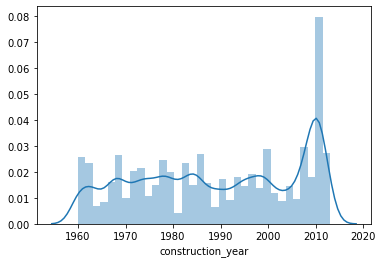

In [230]:
sns.distplot(bal_train.construction_year)


In [231]:
bal_train = bal_train.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                    'construction_year', 'management_group', 'permit', 'district_code', 'decade']]

test = test.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                   'construction_year', 'management_group', 'permit', 'district_code', 'decade']]

In [232]:
bal_train = bal_train.fillna('na')
test = test.fillna('na')

In [233]:
bal_train

,waterpoint_type/group,scheme_management/management,basin,region_code,funder/installer,extraction_type/group/class,source,source_type,construction_year,management_group,permit,district_code,decade
21010,communal standpipe,vwc,Lake Nyasa,11,binned,gravity,spring,spring,2009,user-group,False,3,2000-2010
24446,communal standpipe,wua,Internal,21,binned,gravity,spring,spring,2008,user-group,True,1,2000-2010
43971,communal standpipe,wua,Internal,2,binned,gravity,rainwater harvesting,rainwater harvesting,2008,user-group,False,7,2000-2010
22657,communal standpipe multiple/communal standpipe,vwc,Internal,21,binned,submersible,machine dbh,borehole,2003,user-group,True,5,2000-2010
44637,hand pump,vwc,Wami / Ruvu,5,binned,handpump/swn 80,shallow well,shallow well,2000,user-group,True,6,2000-2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49535,communal standpipe multiple/communal standpipe,wua,Pangani,2,central government/rwe,gravity,spring,spring,1968,user-group,True,7,1960-1970
14456,communal standpipe,vwc,Internal,13,unknown,motorpump/mono,machine dbh,borehole,1960,user-group,nan,2,1960-1970
18288,communal standpipe,water board,Pangani,2,binned,gravity,spring,spring,1968,user-group,True,7,1960-1970
51345,other,vwc,Internal,21,central government,other,shallow well,shallow well,1965,user-group,True,3,1960-1970


In [234]:
X_train = bal_train.drop(['construction_year', 'decade'], axis=1)
X_test = test.drop(['construction_year', 'decade'], axis=1)
y_train = bal_train['decade']
y_test = test['decade']

In [235]:
from sklearn.preprocessing import OneHotEncoder

In [236]:
# resetting the index so we can concatenate the one-hot encoded dfs more easily
X_train_all_features = X_train.copy().reset_index().drop("index", axis=1)


def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    
    return ohe, X_train_all_features

def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

# we will need each of these encoders later for transforming the test data

funder_installer_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, 'funder/installer')

extraction_type_group_class_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "extraction_type/group/class")

scheme_management_management_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "scheme_management/management")

management_group_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "management_group")

source_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "source_type")

source_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "source")

waterpoint_type_group_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "waterpoint_type/group")

permit_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "permit")

basin_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "basin")

district_code_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "district_code")

region_code_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "region_code")

X_train_all_features

,adb/dwe,amref,binned,central government,central government/community,central government/district council,central government/dwe,central government/rwe,ces(gmbh)/dwe,community,...,17,18,19,20,21,24,60,80,90,99
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [237]:
y_train.reset_index(drop=True, inplace=True)

In [238]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rfc = RandomForestClassifier()

# cross_val_score(rfc, X_train_all_features, y_train, cv=5)

In [239]:
rfc.fit(X_train_all_features, y_train)

RandomForestClassifier()

In [297]:
X_test_all_features = X_test.copy().reset_index().drop("index", axis=1)

X_test_all_features = encode_and_concat_feature(X_test_all_features, 'funder/installer', funder_installer_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "extraction_type/group/class", extraction_type_group_class_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "scheme_management/management", scheme_management_management_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "management_group", management_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source_type", source_type_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source", source_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "waterpoint_type/group", waterpoint_type_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "permit", permit_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "basin", basin_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "district_code", district_code_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "region_code", region_code_ohe)

In [298]:
predictions = pd.Series(rfc.predict(X_test_all_features)).map(lambda x: np.mean(pd.Series(x.split('-')).map(lambda val: int(val))))

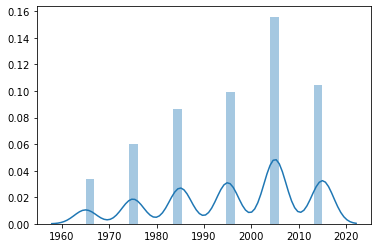

In [299]:
sns.distplot(predictions)

In [300]:
rfc.score(X_train_all_features, y_train)

0.7471166666666667

In [244]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, rfc.predict(X_test_all_features))

array([[ 110,    8,    3,    5,    9,    5],
       [ 137,  712,  111,   35,   73,   47],
       [  95,  115,  964,  147,   72,   63],
       [  38,   49,  266, 1160,  223,  130],
       [ 172,  151,  164,  355, 2187,  773],
       [  51,   37,   45,   79,  229,  853]])

In [245]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

   1960-1970       0.18      0.79      0.30       140
   1970-1980       0.66      0.64      0.65      1115
   1980-1990       0.62      0.66      0.64      1456
   1990-2000       0.65      0.62      0.64      1866
   2000-2010       0.78      0.58      0.66      3802
   2010-2020       0.46      0.66      0.54      1294

    accuracy                           0.62      9673
   macro avg       0.56      0.66      0.57      9673
weighted avg       0.67      0.62      0.63      9673

Accurancy:  0.6188359350770185


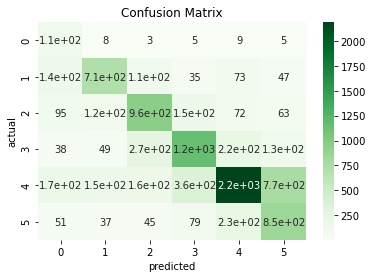

In [246]:
evaluation(y_test, rfc.predict(X_test_all_features))

In [247]:
import pickle

In [301]:
pickle.dump(rfc, open('year_predictor.sav', 'wb'))

pickle.dump(funder_installer_ohe, open('funder_installer_ohe.sav', 'wb'))
pickle.dump(extraction_type_group_class_ohe, open('extraction_type_group_class_ohe.sav', 'wb'))
pickle.dump(scheme_management_management_ohe, open('scheme_management_management_ohe.sav', 'wb'))
pickle.dump(management_group_ohe, open('management_group_ohe.sav', 'wb'))
pickle.dump(source_type_ohe, open('source_type_ohe.sav', 'wb'))
pickle.dump(source_ohe, open('source_ohe.sav', 'wb'))
pickle.dump(waterpoint_type_group_ohe, open('waterpoint_type_group_ohe.sav', 'wb'))
pickle.dump(permit_ohe, open('permit_ohe.sav', 'wb'))
pickle.dump(basin_ohe, open('basin_ohe.sav', 'wb'))
pickle.dump(district_code_ohe, open('district_code_ohe.sav', 'wb'))
pickle.dump(region_code_ohe, open('region_code_ohe.sav', 'wb'))

In [303]:
test = pickle.load(open('funder_installer_ohe.sav', 'rb'))


              precision    recall  f1-score   support

   1960-1970       0.19      0.79      0.31       140
   1970-1980       0.69      0.66      0.67      1115
   1980-1990       0.63      0.68      0.65      1456
   1990-2000       0.68      0.64      0.66      1866
   2000-2010       0.80      0.60      0.69      3802
   2010-2020       0.48      0.69      0.57      1294

    accuracy                           0.64      9673
   macro avg       0.58      0.68      0.59      9673
weighted avg       0.69      0.64      0.65      9673

Accurancy:  0.6418897963403287


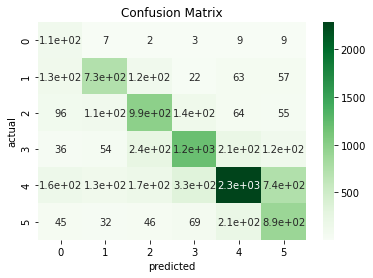

In [99]:
model = pickle.load(open('year_predictor.sav', 'rb'))

evaluation(y_test, model.predict(X_test_all_features))

# What does it suggest?

In [84]:
unknowns = X_train[X_train['construction_year']==0]
unknowns

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source_type,source_class,waterpoint_type,waterpoint_type_group,waterpoint_type/group,scheme_management/management,funder/installer,extraction_type/group,extraction_type/group/class,decade
4,19728,0.0,2011-07-13,action in a,0,artisan,31.130847,-1.825359,Shuleni,0,...,rainwater harvesting,surface,communal standpipe,communal standpipe,communal standpipe,na/other,binned,gravity,gravity,-1960
6,19816,0.0,2012-10-01,dwsp,0,dwsp,33.362410,-3.766365,Kwa Ngomho,0,...,borehole,groundwater,hand pump,hand pump,hand pump,vwc,dwsp,swn 80,handpump/swn 80,-1960
7,54551,0.0,2012-10-09,rwssp,0,dwe,32.620617,-4.226198,Tushirikiane,0,...,shallow well,groundwater,hand pump,hand pump,hand pump,na/wug,rwssp/dwe,nira/tanira,handpump/nira/tanira,-1960
8,53934,0.0,2012-11-03,wateraid,0,water aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,borehole,groundwater,hand pump,hand pump,hand pump,vwc,binned,india mark ii,handpump/india mark ii,-1960
9,46144,0.0,2011-08-03,isingiro ho,0,artisan,30.626991,-1.257051,Kwapeto,0,...,shallow well,groundwater,hand pump,hand pump,hand pump,na/vwc,binned,nira/tanira,handpump/nira/tanira,-1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,72148,0.0,2011-07-10,concern,0,concern,30.667805,-2.483710,Chamkube,0,...,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,binned,gravity,gravity,-1960
59392,40607,0.0,2011-04-15,government of tanzania,0,government,33.009440,-8.520888,Benard Charles,0,...,spring,groundwater,communal standpipe,communal standpipe,communal standpipe,vwc,government of tanzania/government,gravity,gravity,-1960
59393,48348,0.0,2012-10-27,private,0,private,33.866852,-4.287410,Kwa Peter,0,...,dam,surface,other,other,other,water authority/private operator,private,gravity,gravity,-1960
59397,37057,0.0,2011-04-11,na,0,na,34.017087,-8.750434,Mashine,0,...,borehole,groundwater,hand pump,hand pump,hand pump,vwc,na,swn 80,handpump/swn 80,-1960


In [90]:
unk_features = unknowns.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                    'construction_year', 'management_group', 'permit', 'district_code', 'decade']]

In [91]:
unk_features = unk_features.fillna('na')


In [92]:
unk_features = unk_features.drop(['construction_year', 'decade'], axis=1)

In [93]:
all_features = unk_features.copy().reset_index().drop("index", axis=1)

all_features = encode_and_concat_feature(all_features, 'funder/installer', funder_installer_ohe)

all_features = encode_and_concat_feature(all_features, "extraction_type/group/class", extraction_type_group_class_ohe)

all_features = encode_and_concat_feature(all_features, "scheme_management/management", scheme_management_management_ohe)

all_features = encode_and_concat_feature(all_features, "management_group", management_group_ohe)

all_features = encode_and_concat_feature(all_features, "source_type", source_type_ohe)

all_features = encode_and_concat_feature(all_features, "source", source_ohe)

all_features = encode_and_concat_feature(all_features, "waterpoint_type/group", waterpoint_type_group_ohe)

all_features = encode_and_concat_feature(all_features, "permit", permit_ohe)

all_features = encode_and_concat_feature(all_features, "basin", basin_ohe)

all_features = encode_and_concat_feature(all_features, "district_code", district_code_ohe)

all_features = encode_and_concat_feature(all_features, "region_code", region_code_ohe)

In [94]:
all_features

,0,adb/dwe,adra,african/kuwait,amref,binned,ces (gmbh)/dwe,ces(gmbh)/dwe,danida,danida/danid,...,17,18,19,20,21,24,60,80,90,99
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20704,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
predictions = pd.Series(rfc.predict(all_features)).map(lambda x: np.mean(pd.Series(x.split('-')).map(lambda val: int(val))))

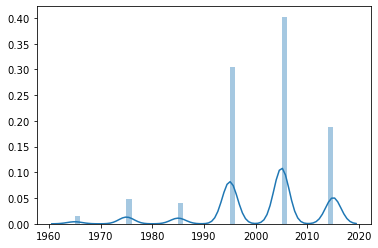

In [96]:
sns.distplot(predictions)

# Imbalanced

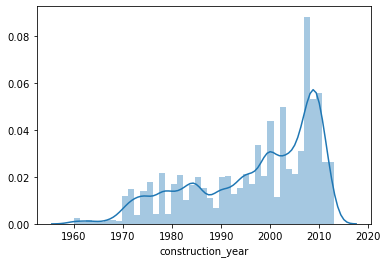

In [26]:
sns.distplot(df['construction_year'])

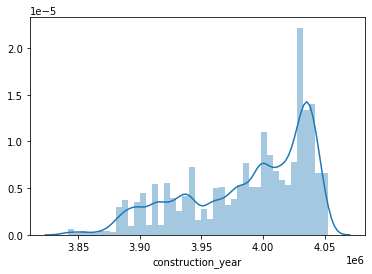

In [27]:
test_dist = np.square(df['construction_year'])

sns.distplot(test_dist)

In [28]:
fsm_data = df.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                    'construction_year', 'management_group', 'permit', 'district_code']]

In [29]:
fsm_data = fsm_data.fillna('na')

In [30]:
fsm_data

,waterpoint_type/group,scheme_management/management,basin,region_code,funder/installer,extraction_type/group/class,source,source_type,construction_year,management_group,permit,district_code
0,communal standpipe,vwc,Lake Nyasa,11,binned,gravity,spring,spring,1999,user-group,False,5
1,communal standpipe,other/wug,Lake Victoria,20,binned,gravity,rainwater harvesting,rainwater harvesting,2010,user-group,True,2
2,communal standpipe multiple/communal standpipe,vwc,Pangani,21,binned,gravity,dam,dam,2009,user-group,True,4
3,communal standpipe multiple/communal standpipe,vwc,Ruvuma / Southern Coast,90,unicef,submersible,machine dbh,borehole,1986,user-group,True,63
5,communal standpipe multiple/communal standpipe,vwc,Pangani,4,mkinga distric coun/dwe,submersible,other,other,2009,user-group,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...
59391,communal standpipe,water authority/vwc,Pangani,3,government of tanzania/government,gravity,river,river/lake,1967,user-group,True,3
59394,communal standpipe,vwc,Wami / Ruvu,5,binned,submersible,machine dbh,borehole,2007,user-group,True,6
59395,communal standpipe,water board,Pangani,3,germany republi/ces,gravity,spring,spring,1999,user-group,True,5
59396,communal standpipe,vwc,Rufiji,11,binned,gravity,river,river/lake,1996,user-group,True,4


In [31]:
from sklearn.model_selection import train_test_split

X = fsm_data.drop('construction_year', axis=1)
y = fsm_data['construction_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [318]:
# resetting the index so we can concatenate the one-hot encoded dfs more easily
X_train_all_features = X_train.copy().reset_index().drop("index", axis=1)


def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    
    return ohe, X_train_all_features

def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

# we will need each of these encoders later for transforming the test data

funder_installer_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, 'funder/installer')

extraction_type_group_class_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "extraction_type/group/class")

scheme_management_management_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "scheme_management/management")

management_group_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "management_group")

source_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "source_type")

source_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "source")

waterpoint_type_group_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "waterpoint_type/group")

permit_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "permit")

basin_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "basin")

district_code_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "district_code")

region_code_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "region_code")

X_train_all_features

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,18,19,20,21,24,40,60,80,90,99
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y_train.reset_index(drop=True, inplace=True)

# Modelling

In [35]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge


lr = LinearRegression()

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
cross_val_score(lr, X_train_all_features, y_train, cv=5)

array([ 4.30004665e-01,  4.15759370e-01,  4.52141674e-01,  4.23622773e-01,
       -6.77405827e+21])

# Lasso

In [38]:
lr = Lasso(alpha=1)

cross_val_score(lr, X_train_all_features, y_train, cv=5)

array([0.03177377, 0.03299093, 0.03378071, 0.03262099, 0.03191777])

# Elastic Net

In [39]:
lr = ElasticNet()

In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
cross_val_score(lr, X_train_all_features, y_train, cv=5)

array([0.03171033, 0.03241636, 0.03277619, 0.03265954, 0.03163872])

# Ridge

In [42]:
lr = Ridge(alpha=1)

cross_val_score(lr, X_train_all_features, y_train, cv=5)

array([0.43011916, 0.4169024 , 0.45233983, 0.42386482, 0.43027249])

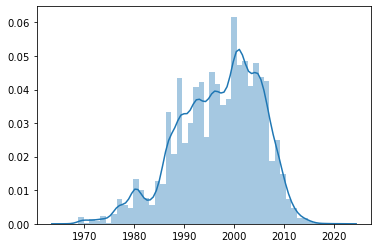

In [43]:
lr.fit(X_train_all_features, y_train)
sns.distplot(lr.predict(X_train_all_features))

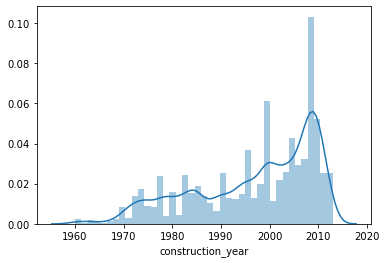

In [44]:
sns.distplot(y_train)

In [45]:
y_hat = lr.predict(X_train_all_features)
lr.score(X_train_all_features, y_train)

0.438328307668748

# Mixed Models

In [46]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

BGM = BayesianGaussianMixture()

In [47]:
cross_val_score(BGM, X_train_all_features, y_train, cv=5)

array([329.29689382, 328.27511728, 326.58488889, 325.13361045,
       143.49613712])

In [48]:
GM = GaussianMixture()

cross_val_score(GM, X_train_all_features, y_train, cv=5)

array([329.70730485, 328.69677258, 327.02570968, 325.59107565,
       145.67275001])

/home/max/anaconda3/envs/tanzania/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


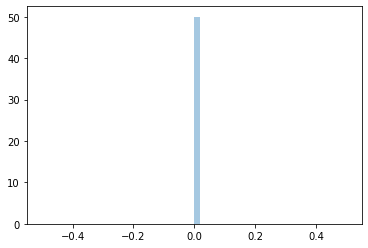

In [49]:
BGM.fit(X_train_all_features, y_train)
sns.distplot(BGM.predict(X_train_all_features))

In [ ]:
def bin_year(year):
    if year<1960:
        return '-1960'
    elif year>=1960 & year<1970:
        return '1960-1970'
    elif year>=1970 & year<1980:
        return '1970-1980'
    elif year>=1980 & year<1990:
        return '1980-1990'
    elif year>=1990 & year<2000:
        return '1990-2000'
    elif year>=2000 & year<2010:
        return '2000-2010'
    elif year>=2010 & year<2020:
        return '2010-2020'

# Random Forest

In [56]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [54]:
rfr = RandomForestRegressor()

In [55]:
cross_val_score(rfr, X_train_all_features, y_train, cv=5)

array([0.6039577 , 0.58381294, 0.613635  , 0.60179066, 0.6052694 ])

In [57]:
rfc = RandomForestClassifier()

In [58]:
Regressor

array([0.4452102 , 0.44469331, 0.44572708, 0.44011718, 0.44252973])

# Testing

In [75]:
X_test_all_features = X_test.copy().reset_index().drop("index", axis=1)

X_test_all_features = encode_and_concat_feature(X_test_all_features, 'funder/installer', funder_installer_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "extraction_type/group/class", extraction_type_group_class_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "scheme_management/management", scheme_management_management_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "management_group", management_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source_type", source_type_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "source", source_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "waterpoint_type/group", waterpoint_type_group_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "permit", permit_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "basin", basin_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "district_code", district_code_ohe)

X_test_all_features = encode_and_concat_feature(X_test_all_features, "region_code", region_code_ohe)

In [76]:
X_test_all_features

,0,adb/dwe,adra,african/kuwait,amref,binned,ces (gmbh)/dwe,ces(gmbh)/dwe,danida,danida/danid,...,18,19,20,21,24,40,60,80,90,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20998,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [63]:
y_test.reset_index(drop=True, inplace=True)

In [64]:
lr.score(X_test_all_features, y_test)

0.43983901245313095

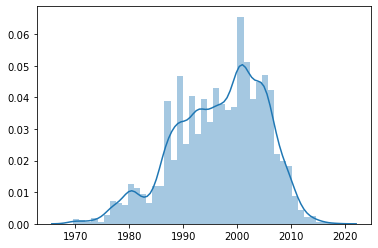

In [65]:
sns.distplot(lr.predict(X_test_all_features))

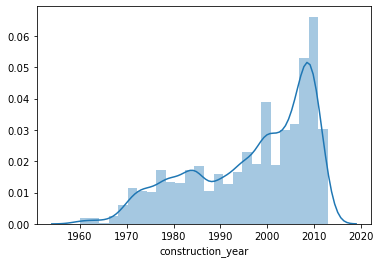

In [66]:
sns.distplot(y_test)